In [1]:
# !pip uninstall matplotlib
# !pip install parse
# !pip install matplotlib --upgrade

In [2]:
!pip show matplotlib

Name: matplotlib
Version: 3.5.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /home/tianchi/anaconda3/envs/ml/lib/python3.9/site-packages
Requires: numpy, kiwisolver, cycler, pillow, fonttools, pyparsing, packaging, python-dateutil
Required-by: seaborn, scikit-image, jupyterthemes


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import pandas as pd
import numpy as np

from parse import *
import os
import sys
import sklearn
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
#%matplotlib auto
import matplotlib.image as mpimg 
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection
from collections import defaultdict
import datetime
from datetime import timedelta
import argparse

# 定义数据基本路径（云端或本地）
colab_datadir = '/content/drive/MyDrive/sharedCodeBase/FamilyAnalysis/'
local_datadir = './'
datadir = local_datadir
sys.path.append(datadir)

from myHelper import *
from graphHelper import *

# 1. 选择家庭

In [5]:
# 定义参数类，替代输入参数
class Myclass():
    MinCountOfPoints=6 #这里我没改，因为分长时间和短时间计算时，我手动一起调了（详见最后一个part）
    MinCountOfPointsForAll=-1
    SizeOfGrid='0.5' # 不需要调 
    figure=datadir+'floorplan01.png' # 默认
    path=datadir+'results_both/' # 默认
    res=datadir+'figures_both/' # 默认
    bySecond=False
    IntervalOfMinutesOrSeconds=1 # 1分钟 1个点  
    setConfig=True #False

arguments=Myclass()


In [6]:

##########################################
# Choose Family
##########################################
family_config = chooseFamily()

max_x = family_config.size[1]
min_x = family_config.size[0]
max_y = family_config.size[3]
min_y = family_config.size[2]

if family_config.name == "ParentsOfSun":
  arguments.figure = datadir+'floorplan01.png'
  arguments.path = datadir+'family1/results_tag0/'
  arguments.res=datadir+'family1/figures_tag0/'
elif family_config.name == "UncleOfSun":
  arguments.figure = datadir+'floorplan02.png'
  arguments.path = datadir+'family2/results_tag0/'
  arguments.res=datadir+'family2/figures_tag0/'
elif family_config.name == "AuntOfSun":
  arguments.figure = datadir+'floorplan03.png'
  arguments.path = datadir+'family3/results_tag2/'
  arguments.res=datadir+'family3/figures_tag2/'
elif family_config.name == "Zeng":
  arguments.figure = datadir+'floorplan04.png'
  arguments.path = datadir+'family4/results_tag1/'
  arguments.res=datadir+'family4/figures_tag1/'
else:
  print("Family doesn't exist !\n")
  exit(0)

# 画图参数
unit = float(arguments.SizeOfGrid)  #网格单元长宽m
column_num = int((max_x-min_x)//unit)
row_num = int((max_y-min_y)//unit)
map_img = mpimg.imread(arguments.figure)

# time epsilon：计算是否算同一区域的最大离开时间
epsilon = 2 #timedelta(minutes=10)
min_count = arguments.MinCountOfPoints

# define time
year = 2022
# 输入路径和结果保存路径
input_path = arguments.path
res_path = arguments.res
createPath(res_path) # 创建路径
C = 0

==>Familiy choices :<== 4
1 :ParentsOfSun
2 :UncleOfSun
3 :AuntOfSun
4 :Zeng
Family of ParentsOfSun is chosen!

Trace familes:
	ParentsOfSun
	size of house : [-2.665, 13.505, -2.2, 10.44]
		Scenario=Shift
			zone 1: OutDoor
				{ x : [-1000.0,-0.0],y : [-1000.0,1000.0] => Delete
			zone 2: OutCanteen
				{ x : [-0.415,1.17],y : [6.773,1000.0] => MoveToDown
			zone kitchen: InKitchen
				{ x : [1.17,3.6],y : [6.785,10.44] => MoveToLeftLinearly
			zone 3: OutKitchen
				{ x : [1.17,3.6],y : [10.44,1000.0] => MoveToDown
			zone 4: OutKitchen
				{ x : [3.6,1000.0],y : [10.44,1000.0] => MoveToLeftDown
			zone 5: OutCanteen
				{ x : [3.6,1000.0],y : [5.37,6.785] => MoveToLeft
			zone 6: OutBalcony
				{ x : [-0.415,6.8],y : [-1000.0,-2.2] => MoveToUp
			zone 7: OutBedRoom
				{ x : [4.115,1000.0],y : [1.085,5.37] => MoveToLeft
Directory  ./family1/figures_tag0/  already exists


# 2. 读取数据并做基本处理

In [7]:
"""
Read Data
"""
# 读取之前生成的数据结果
n = arguments.IntervalOfMinutesOrSeconds
if n == 1:
    if arguments.bySecond:
        end_suffix = '_dataBySecond.xlsx'
    else:
        end_suffix = '_dataByMinute.xlsx'
else:
    if arguments.bySecond:
        end_suffix = '_dataBy'+str(n)+'Seconds.xlsx'
    else:
        end_suffix = '_dataBy'+str(n)+'Minutes.xlsx'
    

# read files
files = [f for f in os.listdir(input_path) if f.endswith(end_suffix)]
# read data
tags_order = []
all_points_array = [] # 记录所有的数据点
'''
dict_df:
key: 'tag0_2022_2_19'等
data: 当天的时间-点值 dataframe
'''
dict_df = {} # 字典形式
fixed_dict_df = {} # 修正后的字典
list_df = [] # 
# data collection for one
data_collection = []

if arguments.MinCountOfPointsForAll == -1:
    C = min_count * len(files)
else:
    C = arguments.MinCountOfPointsForAll

    

for f in files:
    df = pd.read_excel(open(input_path+f,'rb'))

    ### 统计某一时间段的数据
    # interval = [7,12]
    # df = df[ (df["hour"]>=interval[0]) & (df["hour"] <interval[1])] 

    # 修改门口坐标
    ## 第一户（父母家） tag0
    df.loc[(((abs(df['x值']-3.341428571)<0.0001)& (abs(df['y值']-4.33)<0.0001))|            
            ((abs(df['x值']-2.962)<0.0001) & (abs(df['y值']-4.895)<0.0001))|
            ((abs(df['x值']-3.32)<0.0001) & (abs(df['y值']-5.235)<0.0001))|
            ((abs(df['x值']-3.15)<0.0001) & (abs(df['y值']-4.985)<0.0001))|
            ((abs(df['x值']-3.6)<0.0001) & (abs(df['y值']-5.411666667)<0.0001))|
            ((abs(df['x值']-4.115)<0.0001) & (abs(df['y值']-4.62)<0.0001))|
            ((abs(df['x值']-2.98375)<0.0001) & (abs(df['y值']-4.885)<0.0001))|
            ((abs(df['x值']-3.613333333)<0.0001) & (abs(df['y值']-5.256666667)<0.0001))|
            ((abs(df['x值']-2.935)<0.0001) & (abs(df['y值']-4.525)<0.0001))|
            ((abs(df['x值']-3.255714286)<0.0001) & (abs(df['y值']-4.725714286)<0.0001))|
            ((abs(df['x值']-3.26)<0.0001) & (abs(df['y值']-4.892857143)<0.0001))|
            ((abs(df['x值']-3.538)<0.0001) & (abs(df['y值']-4.422)<0.0001))|
            ((abs(df['x值']-3.5325)<0.0001) & (abs(df['y值']-5.8525)<0.0001))|
            ((abs(df['x值']-3.81)<0.0001) & (abs(df['y值']-5.26)<0.0001))|
            ((abs(df['x值']-3.3425)<0.0001) & (abs(df['y值']-4.23625)<0.0001))|
            ((abs(df['x值']-3.28)<0.0001) & (abs(df['y值']-4.64)<0.0001))|
            ((abs(df['x值']-3.182857143)<0.0001) & (abs(df['y值']-5.404285714)<0.0001))|
            ((abs(df['x值']-3.6)<0.0001) & (abs(df['y值']-5.806)<0.0001))|
            ((abs(df['x值']-3.55388287)<0.0001) & (abs(df['y值']-4.477386111)<0.0001))|
            ((abs(df['x值']-3.834)<0.0001) & (abs(df['y值']-4.148)<0.0001))|
            ((abs(df['x值']-4)<0.0001) & (abs(df['y值']-4.27)<0.0001))|
            ((abs(df['x值']-3.835)<0.0001) & (abs(df['y值']-4.44)<0.0001))|
            ((abs(df['x值']-3.84)<0.0001) & (abs(df['y值']-4.64)<0.0001))|
            ((abs(df['x值']-3.53)<0.0001) & (abs(df['y值']-4.39)<0.0001))|
            ((abs(df['x值']-3.63)<0.0001) & (abs(df['y值']-4.5)<0.0001))|
            ((abs(df['x值']-3.77)<0.0001) & (abs(df['y值']-4.67)<0.0001))|
            ((abs(df['x值']-3.71)<0.0001) & (abs(df['y值']-5.095)<0.0001))|
            ((abs(df['x值']-3.388)<0.0001) & (abs(df['y值']-5.268)<0.0001))|
            ((abs(df['x值']-3.63)<0.0001) & (abs(df['y值']-5.22)<0.0001))|
            ((abs(df['x值']-3.67)<0.0001) & (abs(df['y值']-4.5)<0.0001))|
            ((abs(df['x值']-2.823333333)<0.0001) & (abs(df['y值']-5.38)<0.0001))|
            ((abs(df['x值']-4.115)<0.0001) & (abs(df['y值']-5.148571429)<0.0001))|
            ((abs(df['x值']-3.6)<0.0001) & (abs(df['y值']-5.7375)<0.0001))|
            ((abs(df['x值']-3.6)<0.0001) & (abs(df['y值']-5.375)<0.0001))
            ), 'x值'] = 3.5
    df.loc[((abs(df['x值']-3.5)<0.001) & 
            ((abs(df['y值']-4.33)<0.0001) | 
             (abs(df['y值']-4.895)<0.0001)|
             (abs(df['y值']-5.235)<0.0001)|
             (abs(df['y值']-4.985)<0.0001)|
             (abs(df['y值']-5.411666667)<0.0001)|
             (abs(df['y值']-4.62)<0.0001)|
             (abs(df['y值']-4.885)<0.0001)|
             (abs(df['y值']-5.256666667)<0.0001)|
             (abs(df['y值']-4.525)<0.0001)|
             (abs(df['y值']-4.725714286)<0.0001)|
             (abs(df['y值']-4.892857143)<0.0001)|
             (abs(df['y值']-4.422)<0.0001)|
             (abs(df['y值']-5.8525)<0.0001)|
             (abs(df['y值']-5.26)<0.0001)|
             (abs(df['y值']-4.23625)<0.0001)|
             (abs(df['y值']-4.64)<0.0001)|
             (abs(df['y值']-5.404285714)<0.0001)|
             (abs(df['y值']-5.806)<0.0001)|
             (abs(df['y值']-4.477386111)<0.0001)|
             (abs(df['y值']-4.148)<0.0001)|
             (abs(df['y值']-4.27)<0.0001)|
             (abs(df['y值']-4.44)<0.0001)|
             (abs(df['y值']-4.64)<0.0001)|
             (abs(df['y值']-4.39)<0.0001)|
             (abs(df['y值']-4.5)<0.0001)|
             (abs(df['y值']-4.67)<0.0001)|
             (abs(df['y值']-5.095)<0.0001)|
             (abs(df['y值']-5.268)<0.0001)|
             (abs(df['y值']-5.22)<0.0001)|
             (abs(df['y值']-4.5)<0.0001)|
             (abs(df['y值']-5.38)<0.0001)|
             (abs(df['y值']-5.148571429)<0.0001)|
             (abs(df['y值']-5.7375)<0.0001)|
             (abs(df['y值']-5.375)<0.0001)
             )),'y值'] = 5


    ## 第二户（舅舅家） tag0
    # df.loc[(((abs(df['x值']-2.1175)<0.0001) &(abs(df['y值']-6.27)<0.0001))|
    #         ((abs(df['x值']-1.14875)<0.0001) &(abs(df['y值']-1.75875)<0.0001))|
    #         ((abs(df['x值']-1.4475845)<0.0001) &(abs(df['y值']-6.7912643)<0.0001))|
    #         ((abs(df['x值']-1.44)<0.0001) &(abs(df['y值']-6.77999999999999)<0.0001))|
    #         ((abs(df['x值']-1.54444444444445)<0.0001) &(abs(df['y值']-6.5888888888889)<0.0001))|
    #         ((abs(df['x值']-1.53142857142857)<0.0001) &(abs(df['y值']-6.65428571428572)<0.0001))|
    #         ((abs(df['x值']- -0.04)<0.0001) &(abs(df['y值']-6.86000000000001)<0.0001))|
    #         ((abs(df['x值']-1.44666666666667)<0.0001) &(abs(df['y值']-6.57833333333332)<0.0001))|
    #         ((abs(df['x值']-1.364)<0.0001) &(abs(df['y值']-5.886)<0.0001))|
    #         ((abs(df['x值']-2.05)<0.0001) &(abs(df['y值']-7.88333333333333)<0.0001))|
    #         ((abs(df['x值']-1.81)<0.0001) &(abs(df['y值']-7.94)<0.0001))|
    #         ((abs(df['x值']- -0.025)<0.0001) &(abs(df['y值']-5.41833333333333)<0.0001))|
    #         ((abs(df['x值']- -0.04)<0.0001) &(abs(df['y值']-7.05500000000001)<0.0001))|
    #         ((abs(df['x值']-0.38)<0.0001) &(abs(df['y值']-7.89999999999999)<0.0001))|
    #         ((abs(df['x值']-0.35)<0.0001) &(abs(df['y值']-7.505)<0.0001))|
    #         ((abs(df['x值']-1.11)<0.0001) &(abs(df['y值']-6.66000000000001)<0.0001))|
    #         ((abs(df['x值']-1.40833333333333)<0.0001) &(abs(df['y值']-6.71499999999999)<0.0001))|
    #         ((abs(df['x值']-1.34714285714286)<0.0001) &(abs(df['y值']-6.56857142857143)<0.0001))|
    #         ((abs(df['x值']-1.56111111111111)<0.0001) &(abs(df['y值']-6.63333333333333)<0.0001))|
    #         ((abs(df['x值']-1.18)<0.0001) &(abs(df['y值']-6.86200000000001)<0.0001))|
    #         ((abs(df['x值']-0.56125)<0.0001) &(abs(df['y值']-3.25749999999999)<0.0001))|
    #         ((abs(df['x值']-1.5325)<0.0001) &(abs(df['y值']-6.5675)<0.0001))|
    #         ((abs(df['x值']-0.817777777777778)<0.0001) &(abs(df['y值']-6.74333333333334)<0.0001))|
    #         ((abs(df['x值']-1.215)<0.0001) &(abs(df['y值']-6.83)<0.0001))|
    #         ((abs(df['x值']-1.343)<0.0001) &(abs(df['y值']-6.68599999999999)<0.0001))|
    #         ((abs(df['x值']-1.35333333333333)<0.0001) &(abs(df['y值']-6.66166666666667)<0.0001))|
    #         ((abs(df['x值']-0.954444444444446)<0.0001) &(abs(df['y值']-6.77666666666666)<0.0001))|
    #         ((abs(df['x值']-1.28)<0.0001) &(abs(df['y值']-6.62)<0.0001))|
    #         ((abs(df['x值']-1.316)<0.0001) &(abs(df['y值']-6.656)<0.0001))|
    #         ((abs(df['x值']-1.16)<0.0001) &(abs(df['y值']-2.135)<0.0001))|
    #         ((abs(df['x值']-1.21142857142857)<0.0001) &(abs(df['y值']-6.85142857142858)<0.0001))|
    #         ((abs(df['x值']-1.418)<0.0001) &(abs(df['y值']-6.916)<0.0001))|
    #         ((abs(df['x值']-1.2475)<0.0001) &(abs(df['y值']-1.9625)<0.0001))|
    #         ((abs(df['x值']-1.58)<0.0001) &(abs(df['y值']-6.62)<0.0001))|
    #         ((abs(df['x值']-1.552)<0.0001) &(abs(df['y值']-6.85199999999999)<0.0001))|
    #         ((abs(df['x值']-1.47)<0.0001) &(abs(df['y值']-6.35)<0.0001))|
    #         ((abs(df['x值']-1.146)<0.0001) &(abs(df['y值']-6.39600000000001)<0.0001))|
    #         ((abs(df['x值']-1.31)<0.0001) &(abs(df['y值']-6.43666666666667)<0.0001))|
    #         ((abs(df['x值']-1.57444444444444)<0.0001) &(abs(df['y值']-6.56888888888888)<0.0001))|
    #         ((abs(df['x值']-1.2925)<0.0001) &(abs(df['y值']-6.75999999999999)<0.0001))|
    #         ((abs(df['x值']-1.259)<0.0001) &(abs(df['y值']-6.73599999999999)<0.0001))|
    #         ((abs(df['x值']-1.27666666666667)<0.0001) &(abs(df['y值']-6.74833333333333)<0.0001))|
    #         ((abs(df['x值']-1.255)<0.0001) &(abs(df['y值']-6.63)<0.0001))|
    #         ((abs(df['x值']-1.08333333333333)<0.0001) &(abs(df['y值']-6.53333333333334)<0.0001))
    #         ), 'x值'] = 3.0
           
    # df.loc[((abs(df['x值'] - 3.0)<0.0001) & 
    #         ((abs(df['y值']-6.27)<0.0001)| 
    #          (abs(df['y值']-1.75875)<0.0001)|
    #          (abs(df['y值']-6.7912643)<0.0001)|
    #          (abs(df['y值']-6.77999999999999)<0.0001)|
    #          (abs(df['y值']-6.5888888888889)<0.0001)|
    #          (abs(df['y值']-6.77999999999999)<0.0001)|
    #          (abs(df['y值']-6.5888888888889)<0.0001)|
    #          (abs(df['y值']-6.65428571428572)<0.0001)|
    #          (abs(df['y值']-6.86000000000001)<0.0001)|
    #          (abs(df['y值']-6.57833333333332)<0.0001)|
    #          (abs(df['y值']-5.886)<0.0001)|
    #          (abs(df['y值']-7.88333333333333)<0.0001)|
    #          (abs(df['y值']-7.94)<0.0001)|
    #          (abs(df['y值']-5.41833333333333)<0.0001)|
    #          (abs(df['y值']-7.05500000000001)<0.0001)|
    #          (abs(df['y值']-7.89999999999999)<0.0001)|
    #          (abs(df['y值']-7.505)<0.0001)|
    #          (abs(df['y值']-6.66000000000001)<0.0001)|
    #          (abs(df['y值']-6.71499999999999)<0.0001)|
    #          (abs(df['y值']-6.56857142857143)<0.0001)|
    #          (abs(df['y值']-6.63333333333333)<0.0001)|
    #          (abs(df['y值']-6.86200000000001)<0.0001)|
    #          (abs(df['y值']-3.25749999999999)<0.0001)|
    #          (abs(df['y值']-6.5675)<0.0001)|
    #          (abs(df['y值']-6.83)<0.0001)|
    #          (abs(df['y值']-6.74333333333334)<0.0001)|
    #          (abs(df['y值']-6.68599999999999)<0.0001)|
    #          (abs(df['y值']-6.66166666666667)<0.0001)|
    #          (abs(df['y值']-6.77666666666666)<0.0001)|
    #          (abs(df['y值']-6.62)<0.0001)|
    #          (abs(df['y值']-6.656)<0.0001)|
    #          (abs(df['y值']-2.135)<0.0001)|
    #          (abs(df['y值']-6.85142857142858)<0.0001)|
    #          (abs(df['y值']-6.916)<0.0001)|
    #          (abs(df['y值']-1.9625)<0.0001)|
    #          (abs(df['y值']-6.62)<0.0001)|
    #          (abs(df['y值']-6.85199999999999)<0.0001)|
    #          (abs(df['y值']-6.35)<0.0001)|
    #          (abs(df['y值']-6.39600000000001)<0.0001)|
    #          (abs(df['y值']-6.43666666666667)<0.0001)|
    #          (abs(df['y值']-6.56888888888888)<0.0001)|
    #          (abs(df['y值']-6.75999999999999)<0.0001)|
    #          (abs(df['y值']-6.73599999999999)<0.0001)|
    #          (abs(df['y值']-6.74833333333333)<0.0001)|
    #          (abs(df['y值']-6.63)<0.0001)|
    #          (abs(df['y值']-6.53333333333334)<0.0001)
    #          )),'y值'] = 5.0
    
  ## 第二户（舅舅家） tag1
#     df.loc[(((abs(df['x值']- 0.3225)<0.0001)& (abs(df['y值']-6.3725)<0.0001))|
#             ((abs(df['x值']- -0.14)<0.0001)& (abs(df['y值']-5.12)<0.0001))|
#             ((abs(df['x值']- 1.61333333333333)<0.0001) & (abs(df['y值']-6.97166666666668)<0.0001))|
#             ((abs(df['x值']- 0.378333333333334)<0.0001)& (abs(df['y值']-6.40166666666666)<0.0001))|
#             ((abs(df['x值']- 0.656999999999999)<0.0001) & (abs(df['y值']-6.48)<0.0001))|
#             ((abs(df['x值']- 0.55)<0.0001) & (abs(df['y值']-6.47000000000001)<0.0001))|
#             ((abs(df['x值']- 2.77142857142857)<0.0001) & (abs(df['y值']-4.45285714285714)<0.0001))|
#             ((abs(df['x值']- -0.03)<0.0001) & (abs(df['y值']-6.97000000000001)<0.0001))|
#             ((abs(df['x值']- 1.08333333333333)<0.0001)& (abs(df['y值']-7.36166666666668)<0.0001))|
#             ((abs(df['x值']- -0.065)<0.0001) & (abs(df['y值']-7.455)<0.0001))|
#             ((abs(df['x值']- 0.903999999999998)<0.0001) & (abs(df['y值']-6.63)<0.0001))|
#             ((abs(df['x值']- 0.725000000000001)<0.0001) & (abs(df['y值']-6.69999999999999)<0.0001))|
#             ((abs(df['x值']- 0.855714285714285)<0.0001) & (abs(df['y值']-7.46857142857142)<0.0001))|
#             ((abs(df['x值']- 0.76)<0.0001) & (abs(df['y值']-6.76666666666666)<0.0001))|
#             ((abs(df['x值']- 0.335000000000001)<0.0001) & (abs(df['y值']-5.75)<0.0001))|
#             ((abs(df['x值']- -0.205)<0.0001) & (abs(df['y值']-6.36000000000001)<0.0001))|
#             ((abs(df['x值']- 1.75)<0.0001) & (abs(df['y值']-9.435)<0.0001))|
#             ((abs(df['x值']- 0.86)<0.0001) & (abs(df['y值']-6.58)<0.0001))|
#             ((abs(df['x值']- 0.414999999999999)<0.0001) & (abs(df['y值']-6.81)<0.0001))|
#             ((abs(df['x值']- 2.8375)<0.0001) & (abs(df['y值']-4.585)<0.0001))|
#             ((abs(df['x值']- 0.445)<0.0001) & (abs(df['y值']-6.50999999999999)<0.0001))|
#             ((abs(df['x值']- 0.899999999999999)<0.0001) & (abs(df['y值']-5.31999999999999)<0.0001))|
#             ((abs(df['x值']- 0.04)<0.0001) & (abs(df['y值']-6.13)<0.0001))|
#             ((abs(df['x值']- 1.05)<0.0001) & (abs(df['y值']-6.65333333333333)<0.0001))|
#             ((abs(df['x值']- 0.82)<0.0001) & (abs(df['y值']-7.19428571428572)<0.0001))|
#             ((abs(df['x值']- 1.11)<0.0001) & (abs(df['y值']-6.60000000000001)<0.0001))|
#             ((abs(df['x值']- 0.355)<0.0001) & (abs(df['y值']-6.60833333333333)<0.0001))|
#             ((abs(df['x值']- 0.420000000000001)<0.0001) & (abs(df['y值']-7.06999999999999)<0.0001))|
#             ((abs(df['x值']- 0.44)<0.0001) & (abs(df['y值']-5.56999999999999)<0.0001))|
#             ((abs(df['x值']- 2.775)<0.0001) & (abs(df['y值']-4.63)<0.0001))|
#             ((abs(df['x值']- 3.88)<0.0001) & (abs(df['y值']-8.41750000000001)<0.0001))|
#             ((abs(df['x值']- 1.393)<0.0001) & (abs(df['y值']-7.408)<0.0001))|
#             ((abs(df['x值']- 0.292)<0.0001) & (abs(df['y值']-6.08600000000001)<0.0001))      
#             ), 'x值'] = 3.0
           
#     df.loc[((abs(df['x值'] - 3.0)<0.0001) & 
#             ((abs(df['y值']-6.3725)<0.0001) | 
#              (abs(df['y值']-5.12)<0.0001)|
#              (abs(df['y值']-6.97166666666668)<0.0001)|
#              (abs(df['y值']-6.40166666666666)<0.0001)|
#              (abs(df['y值']-6.48)<0.0001)|
#              (abs(df['y值']-6.47000000000001)<0.0001)|
#              (abs(df['y值']-4.45285714285714)<0.0001)|
#              (abs(df['y值']-6.97000000000001)<0.0001)|
#              (abs(df['y值']-7.36166666666668)<0.0001)|
#              (abs(df['y值']-7.455)<0.0001)|
#              (abs(df['y值']-6.63)<0.0001)|
#              (abs(df['y值']-6.69999999999999)<0.0001)|
#              (abs(df['y值']-7.46857142857142)<0.0001)|             
#              (abs(df['y值']-6.76666666666666)<0.0001)|
#              (abs(df['y值']-5.75)<0.0001)|
#              (abs(df['y值']-6.36000000000001)<0.0001)|
#              (abs(df['y值']-9.435)<0.0001)|
#              (abs(df['y值']-6.58)<0.0001)|
#              (abs(df['y值']-6.81)<0.0001)|
#              (abs(df['y值']-4.585)<0.0001)|
#              (abs(df['y值']-6.50999999999999)<0.0001)|
#              (abs(df['y值']-5.31999999999999)<0.0001)|       
#              (abs(df['y值']-6.13)<0.0001)|
#              (abs(df['y值']-6.65333333333333)<0.0001)|
#              (abs(df['y值']-7.19428571428572)<0.0001)|      
#              (abs(df['y值']-6.60000000000001)<0.0001)|
#              (abs(df['y值']-6.60833333333333)<0.0001)|      
#              (abs(df['y值']-7.06999999999999)<0.0001)|
#              (abs(df['y值']-5.56999999999999)<0.0001)|      
#              (abs(df['y值']-4.63)<0.0001)|
#              (abs(df['y值']-8.41750000000001)<0.0001)|
#              (abs(df['y值']-7.408)<0.0001)|
#              (abs(df['y值']-6.08600000000001)<0.0001)
#              )),'y值'] = 5.0
  ## 第三户（姨妈家） tag0 无
  ## 第三户（姨妈家） tag1
    # df.loc[(((abs(df['x值']- 5.625)<0.0001)& (abs(df['y值']-(-0.24))<0.0001))|
    #         ((abs(df['x值']- 5.046)<0.0001)& (abs(df['y值']-1.014)<0.0001))|
    #         ((abs(df['x值']- 5.31999999999999)<0.0001)& (abs(df['y值']-(-0.403333333333333))<0.0001))|
    #         ((abs(df['x值']- 6.67)<0.0001)& (abs(df['y值']-(-0.789999999999999))<0.0001))|            
    #         ((abs(df['x值']- 4)<0.0001) & (abs(df['y值']-(-3.41))<0.0001))      
    #         ), 'x值'] = 2.5
    # df.loc[((abs(df['x值'] - 2.5)<0.0001) & 
    #         ((abs(df['y值']-(-0.24))<0.0001) | 
    #          (abs(df['y值']-1.014)<0.0001)|
    #          (abs(df['y值']-(-0.403333333333333))<0.0001)|
    #          (abs(df['y值']-(-0.789999999999999))<0.0001)|
    #          (abs(df['y值']-(-3.41))<0.0001)
    #          )),'y值'] = 7.5
  
  ## 第三户（姨妈家） tag2
    # df.loc[(((abs(df['x值']-3.384444444)<0.0001)& (abs(df['y值']-3.915555556)<0.0001))|            
    #         ((abs(df['x值']-11.53)<0.0001) & (abs(df['y值']-3.666666667)<0.0001))      
    #         ), 'x值'] = 2.5
    # df.loc[((abs(df['x值']-2.5)<0.0001) & 
    #         ((abs(df['y值']-3.915555556)<0.0001) | 
    #          (abs(df['y值']-3.666666667)<0.0001)
    #          )),'y值'] = 7.5

  ## 第四户（曾云一家） tag0
    # df.loc[(((abs(df['x值']-2.75)<0.0001)& (abs(df['y值']-0.29)<0.0001))      
    #         ), 'x值'] = 0
    # df.loc[((abs(df['x值']-0)<0.0001) & 
    #         ((abs(df['y值']-0.29)<0.0001)
    #          )),'y值'] = -1
  ## 第四户（曾云一家） tag1
    # df.loc[(((abs(df['x值']-6.503333333)<0.0001)& (abs(df['y值']-1.25)<0.0001))      
    #         ), 'x值'] = 0
    # df.loc[((abs(df['x值']-0)<0.0001) & 
    #         ((abs(df['y值']-1.25)<0.0001)
    #          )),'y值'] = -1
  ## 第四户（曾云一家） tag2
    # df.loc[(((abs(df['x值']-3.42)<0.0001)& (abs(df['y值']-0.54)<0.0001))|            
    #         ((abs(df['x值']-2.74)<0.0001) & (abs(df['y值']-0.4)<0.0001))|
    #         ((abs(df['x值']-3.46)<0.0001) & (abs(df['y值']-0.4081818182)<0.0001))|
    #         ((abs(df['x值']-3.42)<0.0001) & (abs(df['y值']-0.47)<0.0001))|               
    #         ((abs(df['x值']-3.24)<0.0001) & (abs(df['y值']-0.1)<0.0001))
    #         ), 'x值'] = 0
    # df.loc[((abs(df['x值']-0)<0.0001) & 
    #         ((abs(df['y值']-0.54)<0.0001)| 
    #          (abs(df['y值']-0.4)<0.0001)|
    #          (abs(df['y值']-0.4081818182)<0.0001)|
    #          (abs(df['y值']-0.47)<0.0001)|
    #          (abs(df['y值']-0.1)<0.0001)
    #          )),'y值'] = -1
  ## 第四户（曾云一家） tag3
    # df.loc[(((abs(df['x值']-0.95)<0.0001)& (abs(df['y值']-2.52)<0.0001))|            
    #         ((abs(df['x值']-2.98)<0.0001) & (abs(df['y值']-0.415)<0.0001))|
    #         ((abs(df['x值']-0.94)<0.0001) & (abs(df['y值']-1.19)<0.0001))|
    #         ((abs(df['x值']-3.57)<0.0001) & (abs(df['y值']-2.7)<0.0001))
    #         ), 'x值'] = 0
    # df.loc[((abs(df['x值']-0)<0.0001) & 
    #         ((abs(df['y值']-2.52)<0.0001)| 
    #          (abs(df['y值']-0.415)<0.0001)|
    #          (abs(df['y值']-1.19)<0.0001)|
    #          (abs(df['y值']-2.7)<0.0001)
    #          )),'y值'] = -1

    ori_df = df.copy()# store the non-shifted points
    # shift data 修正带有传感器误差的数据
    if arguments.setConfig :
        #print("==========>Start Shifting<============")
        df = shift(family_config,df)
        #print("==========>End Shifting<============")
        # print(df_temp)

    # one copy of df
    df_copy = df.copy()

    # 提取日期信息
    parsed = parse("{}_{}_{}",f)
    my_date = str(year)+'-'+parsed[1][:2]+'-'+parsed[1][2:]
    date = str(dt.datetime.strptime(my_date, '%Y-%m-%d').date())

    points = []
    old_points = []
    key = parsed[0]+"_"+my_date 

    # 循环记录所有的点（包括修正前和修正后）
    # 同时对修正后的数据的时间增加日期
    for i in range(len(df['hour'])):
        point = [df['x值'][i],df['y值'][i]]
        old_point = [ori_df['x值'][i],ori_df['y值'][i]]
        points.append(point)
        old_points.append(old_point)
        data_collection.append(point)
            
        # define new time for all in one
        # TODO : if necessary, to change all dataframe time
        new_time = pd.to_datetime(date + " " + df['time'][i].strftime("%H:%M:%S"))
        #df_copy['time'][i] = new_time
        df_copy.at[i,'time'] = new_time

    points_array = np.array(points)
    old_points_array = np.array(old_points)
    
    # create non-shifted scatter
    if len(old_points_array)==0: continue
    createScatter(old_points_array,key,map_img,res_path,max_x,min_x,max_y,min_y)
    #createScatter(points_array,key,map_img,res_path,max_x,min_x,max_y,min_y)

    tags_order.append(parsed[0])
    all_points_array.append(points_array)
        
    dict_df[key] =df_copy # change the time
    #fixed_dict_df[key] = df_copy
    #print(all_points_array)
    list_df.append(df_copy)
    
print("==========>Finish Reading<============")


==========>Finish Reading<============


# 3. 对整周/整段时间的数据整理

## Dataframe 格式

In [8]:
# collect all data by concatinate all dataframe to one
data_collection_array = np.array(data_collection)
df_week = pd.concat(list_df,sort=False)
# NOTE : necessary ! to remove the index for series in dataframe
df_week.reset_index(drop=True, inplace=True)
nb_record = len(all_points_array)

print("read files :",files)
print("有{}组数据/天".format(nb_record))




read files : ['tag0_0207_dataByMinute.xlsx', 'tag0_0211_dataByMinute.xlsx', 'tag0_0213_dataByMinute.xlsx', 'tag0_0202_dataByMinute.xlsx', 'tag0_0208_dataByMinute.xlsx', 'tag0_0205_dataByMinute.xlsx', 'tag0_0204_dataByMinute.xlsx', 'tag0_0210_dataByMinute.xlsx', 'tag0_0203_dataByMinute.xlsx', 'tag0_0206_dataByMinute.xlsx', 'tag0_0212_dataByMinute.xlsx', 'tag0_0209_dataByMinute.xlsx']
有12组数据/天


## 画散点图

In [9]:
'''
shifted_scatter_allIn 数据清理后，总共14天的散点图
'''
fig,ax = plt.subplots(figsize=(int(max_x-min_x),int(max_y-min_y)))
ax.scatter(data_collection_array[:,0],data_collection_array[:,1],s=20) # data_collection_array: 第一列：x;第二列：y 排数=点数
plt.imshow(map_img,zorder = 0, extent=[min_x,max_x,min_y,max_y])
fig.savefig(res_path+"shifted_scatter_allInOne.png",dpi=300)
plt.close(fig)

## 初步分析：
每日在家时间统计；生成网格

In [10]:
'''
统计每天的在家时间
'''
number_cluster={}  # key=日期 value=当天的聚类数
totaltimes=pd.DataFrame(columns=['date','TimeAtHome']) 
dict_zones_dict={}
for key in dict_df.keys():
    data = collectData(dict_df,key)

    if(data.empty): continue
    data,groups,grids = createGrid(data,key,column_num,row_num,max_x,min_x,max_y,min_y)
    # 备注（给开发人员）：data作为可变对象传入函数，在createGrid被修改，因此修改的结果会保存到函数外部
    # label是每个网格的编号
    # groups 记录每个label内的数据点个数
    # grids 按照矩阵格式记录每个网格的占比 \sqrt{当前网格中的点数/最大网格中的点数}
    # 记录每一天的在家时间
    totaltime=len(data)
    new_time=pd.DataFrame([[key, totaltime]],columns=['date','TimeAtHome'])
    totaltimes=totaltimes.append(new_time,ignore_index=True)

print(totaltimes)


    

/tmp/ipykernel_68837/2016060882.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_68837/2016060882.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_68837/2016060882.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_68837/2016060882.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_68837/2016060882.py:19: FutureWarning: The frame.append metho

               date TimeAtHome
0   tag0_2022-02-07        812
1   tag0_2022-02-11        562
2   tag0_2022-02-13        330
3   tag0_2022-02-02        271
4   tag0_2022-02-08        430
5   tag0_2022-02-05        273
6   tag0_2022-02-04        642
7   tag0_2022-02-10        606
8   tag0_2022-02-03        825
9   tag0_2022-02-06         72
10  tag0_2022-02-12         37
11  tag0_2022-02-09        399


/tmp/ipykernel_68837/2016060882.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)


## 聚类算法分区+画成热力图

### 整个时间段 ALL

time     2022-02-07 09:27:00
x                        3.5
y                        5.0
label                    461
zone                       0
Name: 26, dtype: object
time     2022-02-07 09:28:00
x                        3.5
y                        5.0
label                    461
zone                       0
Name: 27, dtype: object
time     2022-02-07 09:29:00
x                        3.5
y                        5.0
label                    461
zone                       0
Name: 28, dtype: object
time     2022-02-07 09:30:00
x                        3.5
y                        5.0
label                    461
zone                       0
Name: 29, dtype: object
time     2022-02-07 09:31:00
x                        3.5
y                        5.0
label                    461
zone                       0
Name: 30, dtype: object
time     2022-02-07 09:32:00
x                        3.5
y                        5.0
label                    461
zone                       0
Name: 31, 

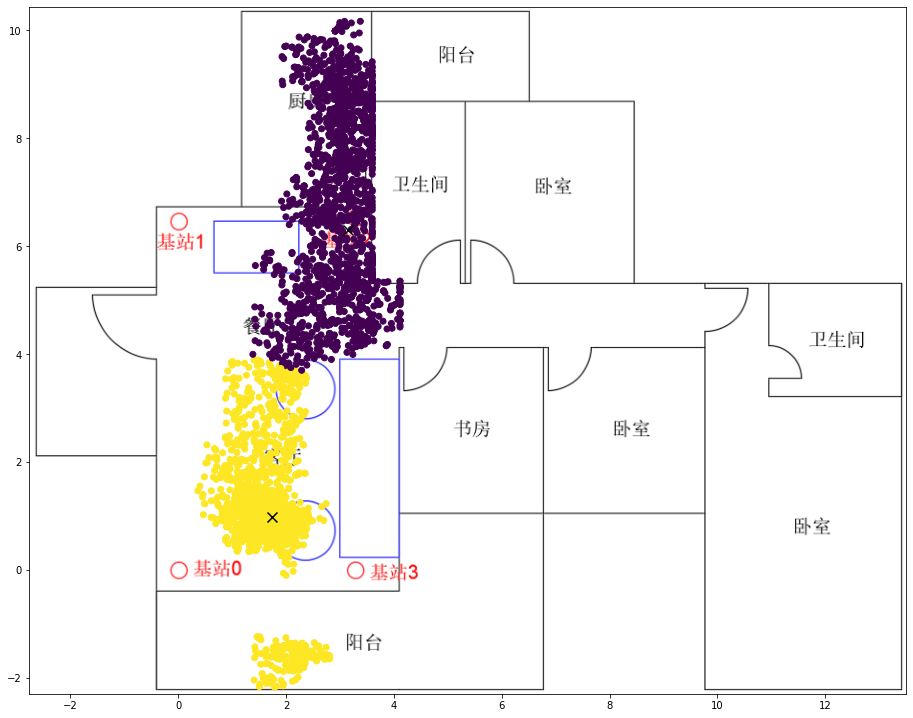

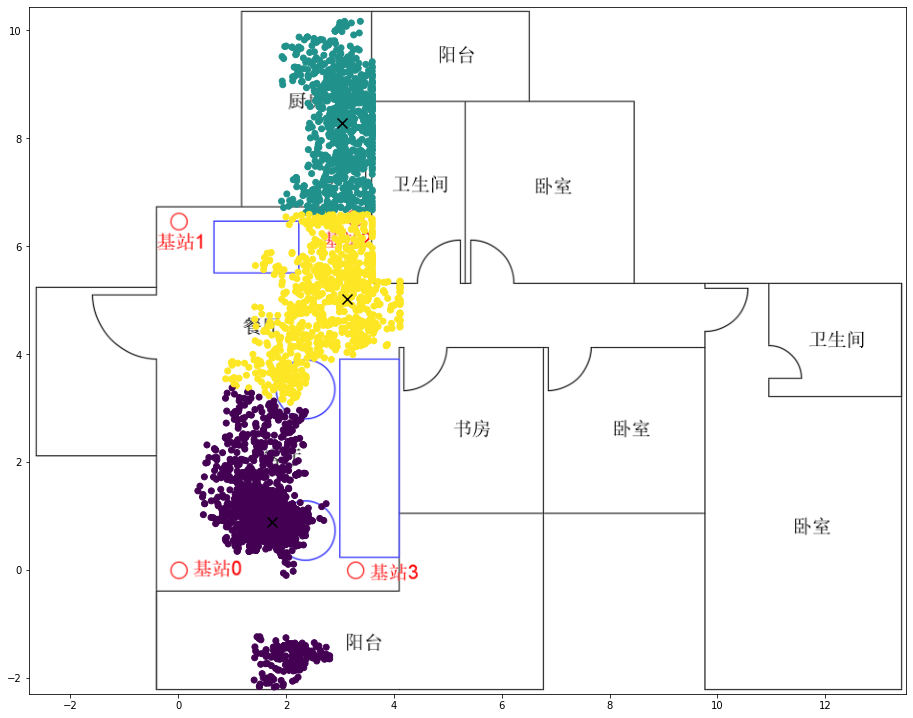

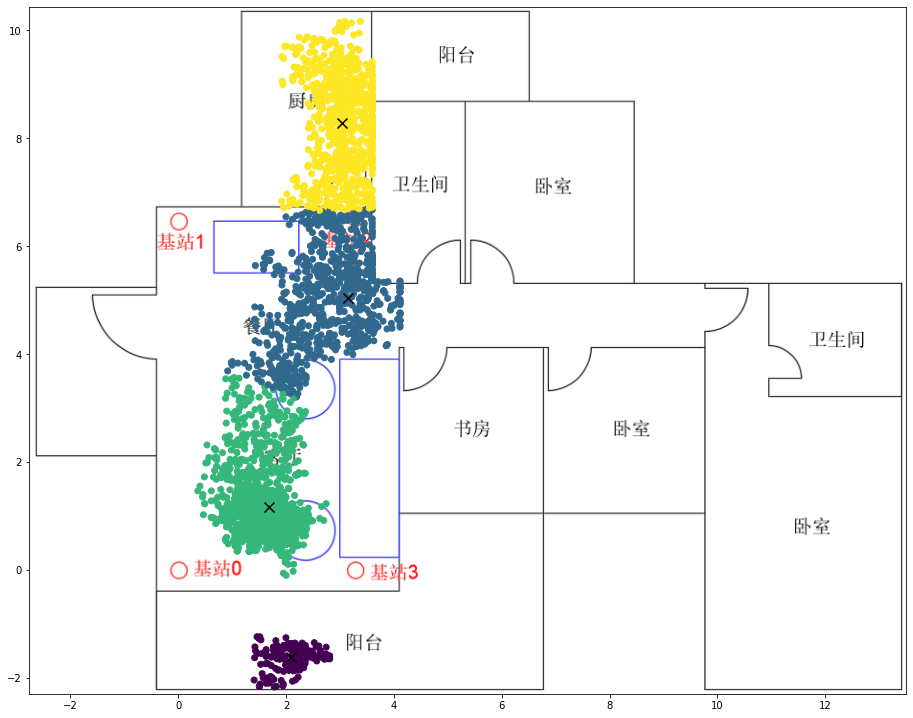

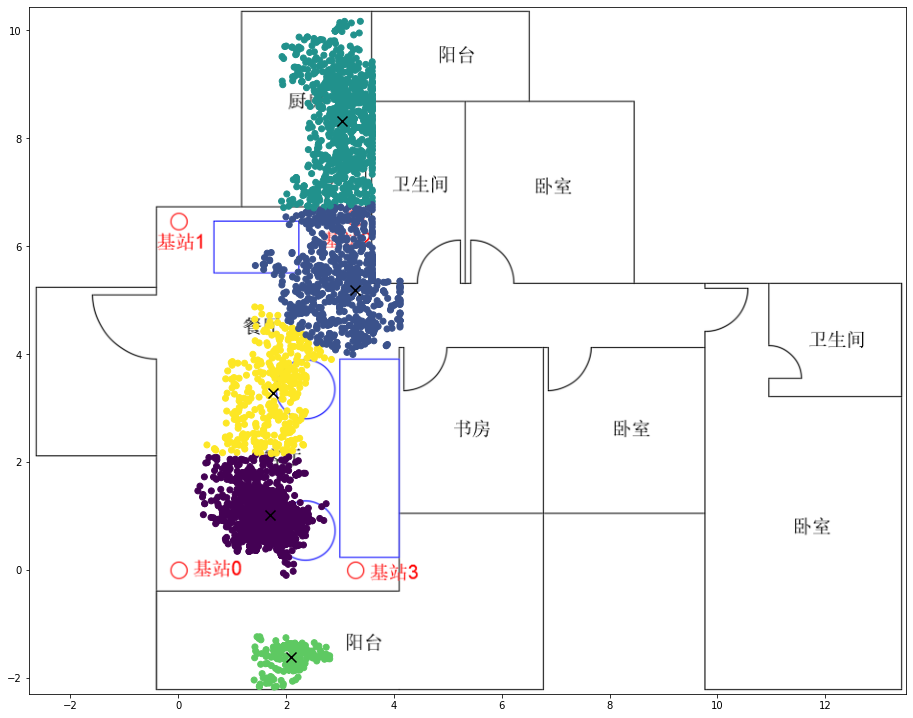

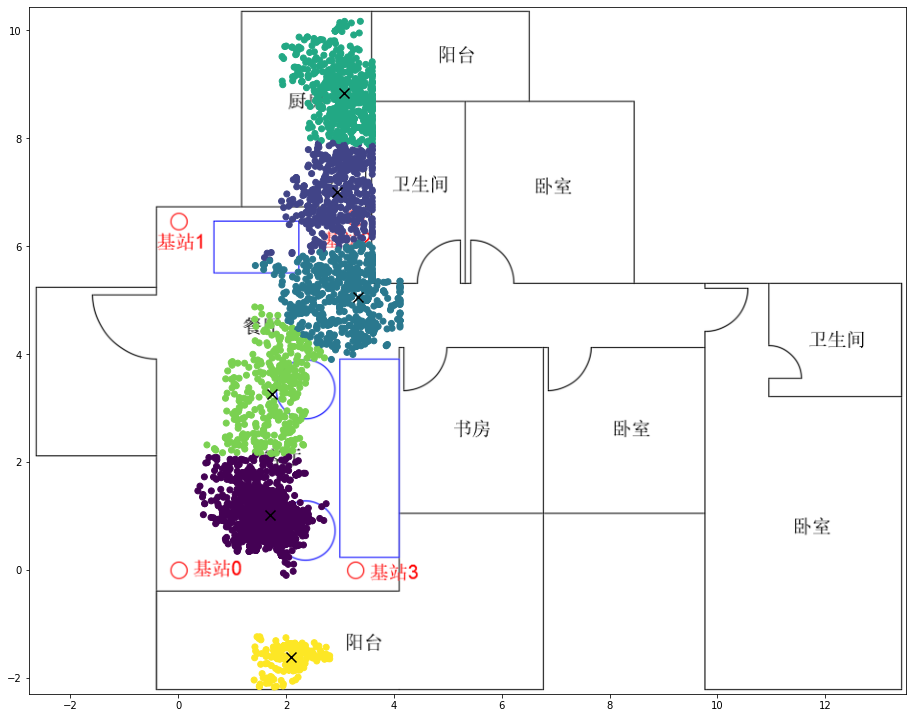

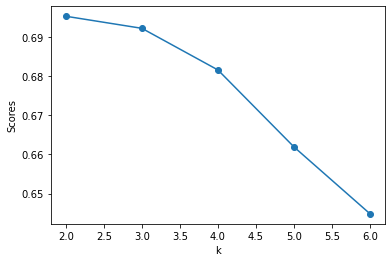

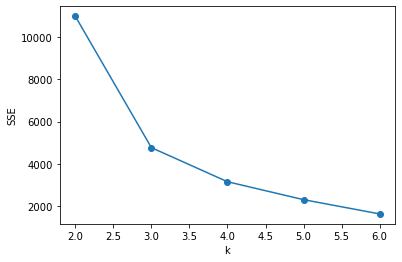

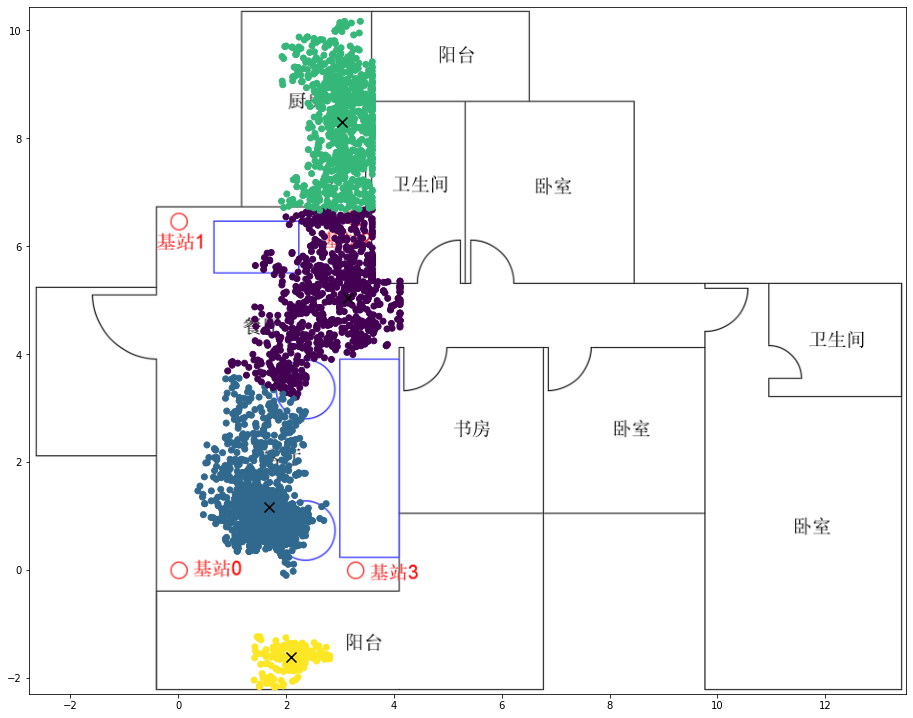

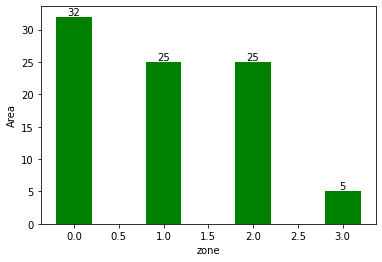

In [11]:
'''
整个14天的分区表示——聚类+画成热力图
'''
key="All"
data_allInOne = collectDataAllInOne(df_week)
data_allInOne,groups,grids = createGrid(data_allInOne,key,column_num,row_num,max_x,min_x,max_y,min_y)
#print(groups,grids)
createHeatmap(grids,"heatmap_allInOne",map_img,res_path,unit,max_x,min_x,max_y,min_y)

# create excel writer object 输出每个点对应的网格
writer = pd.ExcelWriter(datadir+'output.xlsx')
# write dataframe to excel
data_allInOne.to_excel(writer)
# save the excel
writer.save()

 # 删去点数小于min_count的网格中的点——剩余的点更加集中，便于聚类
choice_data_all=choose_spots(data_allInOne,groups,12)
x=choice_data_all['x']
y=choice_data_all['y']
# centers: 聚类后每一类的中心点坐标——根据中心点划定zone的范围
centers_all,y_pre_all = K_m(x,y,key,number_cluster,map_img,res_path,max_x,min_x,max_y,min_y)
choice_data_all['zone']=y_pre_all
# check example of label 461
# for idx,row in choice_data_all.iterrows():
#   if row['label'] == 461 :print(row)


# 保存用于划分常驻区域的数据 （用于advanced analysis）
store_data = choice_data_all.copy()
writer2 = pd.ExcelWriter(datadir+family_config.name+'_choice_data_all.xlsx')
# write dataframe to excel
store_data.to_excel(writer2)
# save the excel
writer2.save()

dict_zones_all= get_dict_zones(choice_data_all,number_cluster[key])
zones_info_forall=get_zone_info("All",dict_zones_all,res_path)
new_grids = createHeatmapByTime(dict_zones_all,"heatmap_allInOne",map_img,res_path,row_num,column_num,unit,max_x,min_x,max_y,min_y,groups)
createHeatmapByTime2(new_grids,"heatmap_allInOne",map_img,res_path,unit,max_x,min_x,max_y,min_y)
# createTimeLine(key,details,res_path)


In [12]:
print(dict_zones_all)

{0: [556, 523, 393, 361, 491, 525, 428, 493, 362, 492, 460, 430, 429, 426, 459, 461, 427, 462, 396, 394, 524, 557, 555, 490, 395, 458, 425, 360, 489, 554, 330, 397], 1: [263, 329, 168, 199, 266, 233, 232, 201, 234, 298, 202, 265, 330, 203, 170, 297, 200, 296, 264, 328, 138, 169, 360, 231, 361], 2: [587, 653, 588, 714, 556, 557, 620, 619, 554, 586, 555, 716, 683, 747, 748, 746, 715, 684, 651, 685, 621, 652, 589, 717, 780], 3: [42, 9, 10, 43, 41]}


### 按在家时间长短分为两类分析

In [13]:
'''
按在家时间长短分为两类分析
首先处理数据，将数据分为两类并整合
'''
    
list_long_df=[]
list_short_df=[]
list_mid_df=[]

for idx,row in totaltimes.iterrows():
    if row['TimeAtHome']>600: # 10h以上 长时间
        list_long_df.append(collectData(dict_df,row['date']))
    elif row['TimeAtHome']<300: # 5h以下 短时间
        list_short_df.append(collectData(dict_df,row['date']))
    else:
        list_mid_df.append(collectData(dict_df,row['date']))

df_long = pd.concat(list_long_df,sort=False)
df_long.reset_index(drop=True, inplace=True) 

df_short = pd.concat(list_short_df,sort=False)
df_short.reset_index(drop=True, inplace=True) 

df_mid = pd.concat(list_mid_df,sort=False)
df_mid.reset_index(drop=True, inplace=True) 


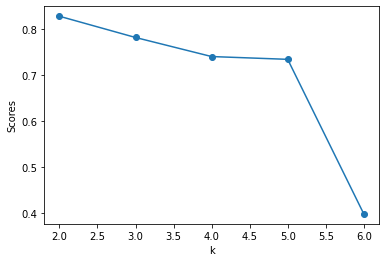

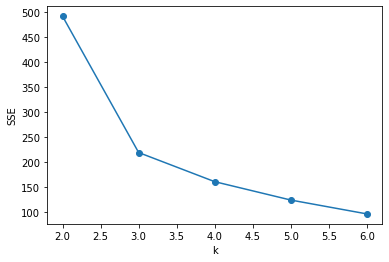

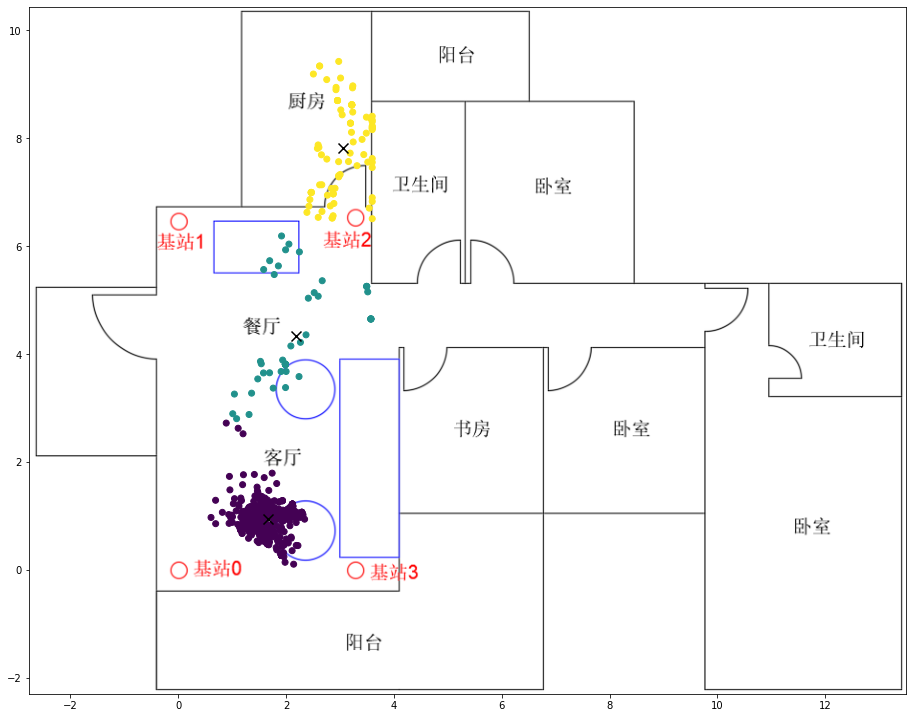

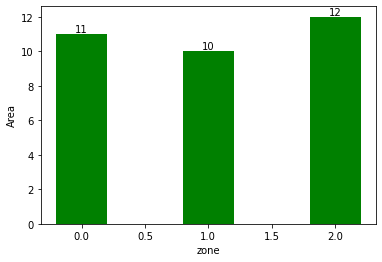

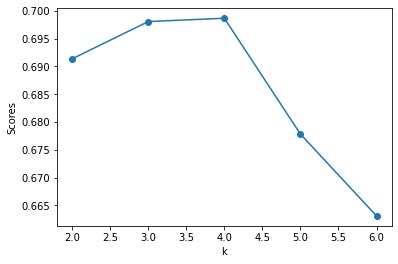

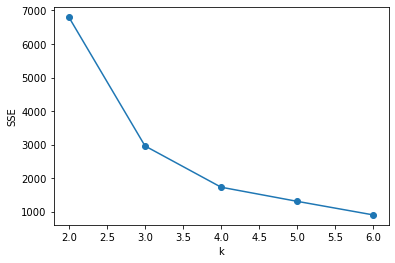

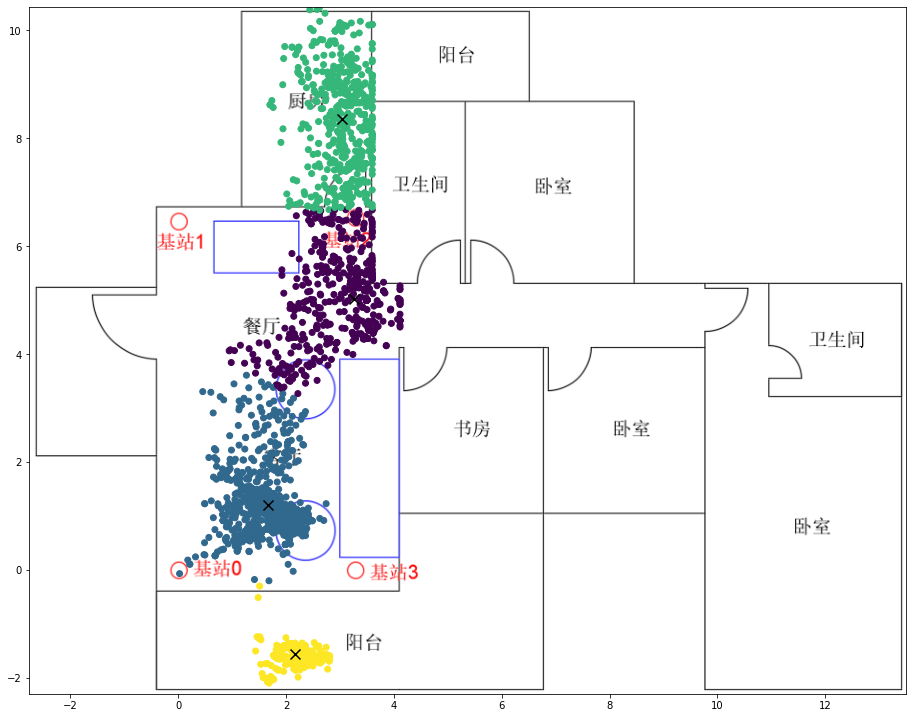

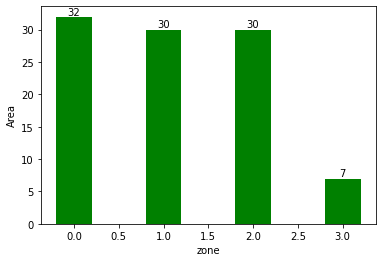

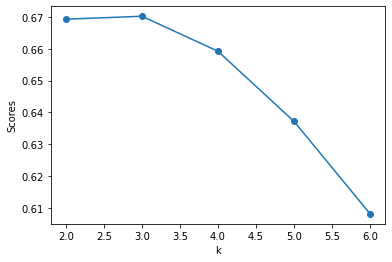

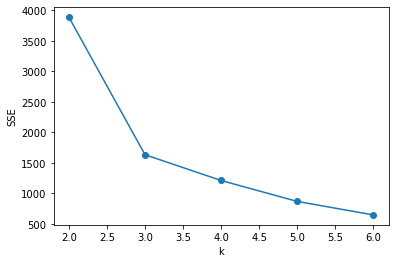

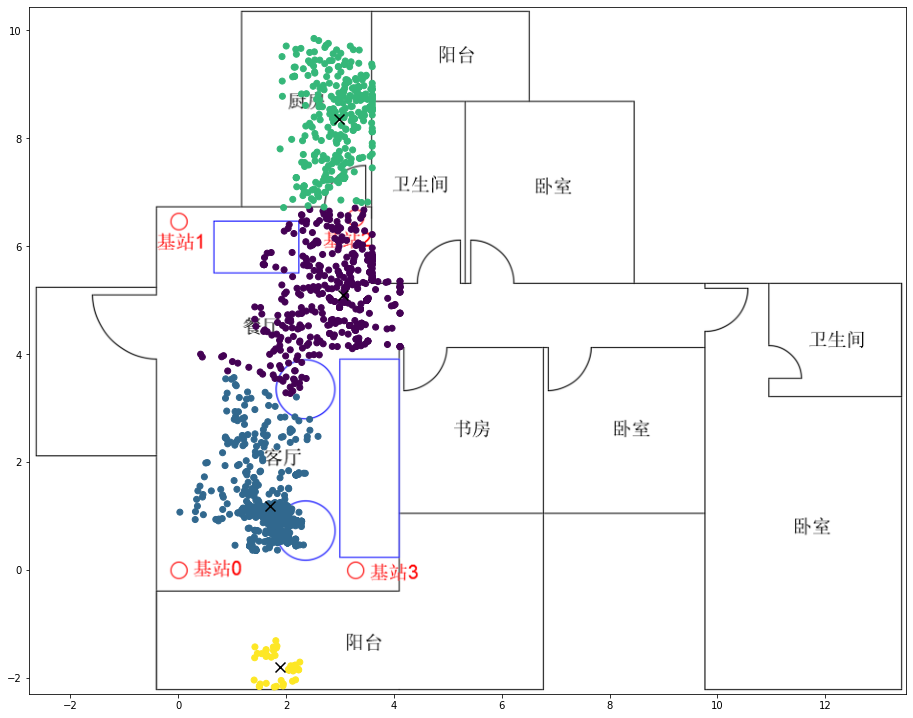

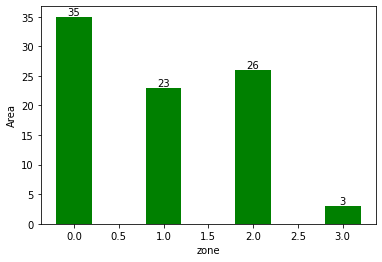

In [14]:
'''
短时段在家的情况：totaltimes[key]<300
'''
# print(list_short_df)
zones_info_short=FinalAnalysis(df_short,"short",len(list_short_df)*1,number_cluster,
                                epsilon,row_num,column_num,map_img,res_path,unit,
                                max_x,min_x,max_y,min_y,groups,family_config.name,withTimeLine=1)

'''
长时段在家的情况：totaltimes[key]>600
'''
zones_info_long=FinalAnalysis(df_long,"long",len(list_long_df)*1,number_cluster,
                                epsilon,row_num,column_num,map_img,res_path,unit,
                                max_x,min_x,max_y,min_y,groups,family_config.name,withTimeLine=1)

'''
中时段在家情况：totaltime[key]∈[300,600]
'''
zones_info_mid=FinalAnalysis(df_mid,"mid",len(list_mid_df)*1,number_cluster,
                                epsilon,row_num,column_num,map_img,res_path,unit,
                                max_x,min_x,max_y,min_y,groups,family_config.name,withTimeLine=1)




       0
1    186
2     70
3     25
4     17
5      6
6      6
7      7
8      7
9      3
10     3
11     2
13     2
14     1
15     3
19     3
22     1
24     1
25     1
27     1
28     1
30     1
42     1
46     1
53     1
55     1
189    1
62     1
71     1
84     1
96     1
zone:0:MTS=0.14606741573033707
     0
1   82
2   38
3   15
4   10
5   14
6   10
7    7
9    4
10   3
11   2
12   5
13   4
14   3
15   3
16   2
17   1
18   1
21   1
22   2
23   2
24   3
26   3
27   1
29   2
30   1
31   1
32   1
34   1
36   1
37   3
38   1
42   1
44   1
45   1
50   1
52   1
55   1
59   1
60   1
63   1
64   1
67   1
84   1
92   1


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


zone:1:MTS=0.3375
     0
1   87
2   39
3   23
4   21
5   19
6   12
7    7
8    2
9    2
10   3
12   2
14   3
15   2
16   1
18   1
19   1
20   1
22   1
23   1
24   1
25   1
31   1
36   1
38   1
46   1


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


zone:2:MTS=0.19230769230769232
    0
1   6
2   3
3   2
4   2
5   3
6   1
7   2
8   2
10  1
11  1
42  1
14  1
20  1
22  1
29  1


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


zone:3:MTS=0.42857142857142855


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


      0
1    93
2    45
3     9
4    10
5     5
6     1
7     3
8     5
9     1
10    2
12    1
14    1
15    1
19    1
22    1
28    1
34    1
189   1
62    1
71    1
84    1
96    1
zone:0:MTS=0.12903225806451613


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


     0
1   41
2   14
3    4
4    4
5    6
6    3
7    7
9    4
10   1
11   1
12   4
13   3
15   3
17   1
21   1
22   1
23   1
24   3
26   2
27   1
29   2
30   1
31   1
32   1
34   1
36   1
37   3
46   1
60   1
92   1
zone:1:MTS=0.4152542372881356
     0
1   40
2   17
3   12
4    6
5    6
6    7
7    3
8    2
9    1
10   1
11   2
13   1
14   1
15   1
17   1
18   1
19   1
20   1
21   1
22   1
29   1
31   1
36   1
38   1


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


zone:2:MTS=0.2636363636363636
    0
32  1
1   4
2   1
3   1
4   1
7   2
10  1
14  1
51  1
22  1
29  1


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


zone:3:MTS=0.5333333333333333


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


    0
1   9
2   7
3   1
4   1
5   1
7   1
9   1
12  1
16  2
49  1
52  1
54  1
23  1
22  1
57  1
26  1
31  1
zone:0:MTS=0.40625


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


     0
1   28
2    1
3    2
5    1
13   1
zone:1:MTS=0.030303030303030304


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


     0
1   15
2    6
3    2
4    2
5    1
6    1
7    1
8    1
18   1
zone:2:MTS=0.13333333333333333


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


     0
1   82
2   24
3   11
4    3
5    4
6    4
7    4
8    1
9    2
11   1
13   1
15   1
19   1
22   1
25   1
27   1
30   1
39   1
44   1
53   1
55   1
zone:0:MTS=0.1564625850340136
     0
1   38
2   15
3    6
4    3
5    5
6    6
7    2
8    1
9    2
10   3
14   1
15   2
16   1
17   1
19   1
22   1
38   1
41   1
42   1
44   1
63   1
66   1


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


zone:1:MTS=0.2872340425531915
     0
32   1
1   18
2   17
3    6
4   10
5   10
6    3
7    4
8    1
12   2
14   2
17   1
23   1
25   1


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


zone:2:MTS=0.2077922077922078
    0
1   4
2   2
3   1
5   2
10  1
20  1


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


zone:3:MTS=0.18181818181818182


/tmp/ipykernel_68837/3445216541.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTS_info=MTS_info.append(newdf,ignore_index=True)


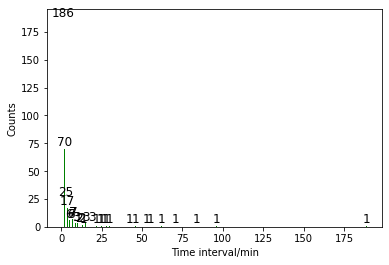

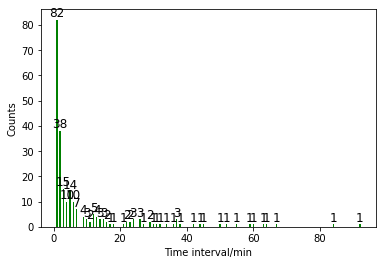

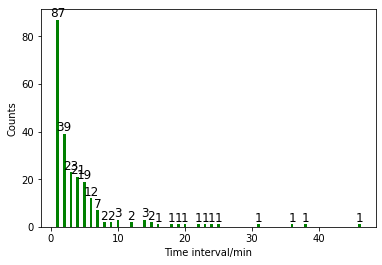

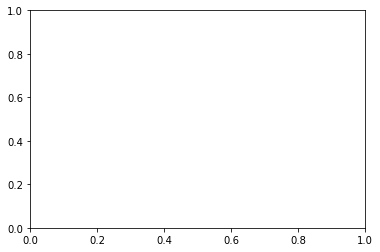

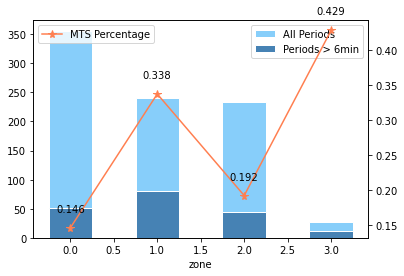

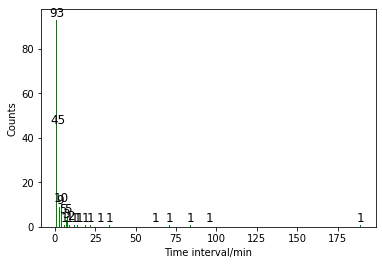

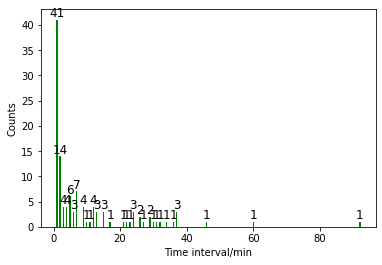

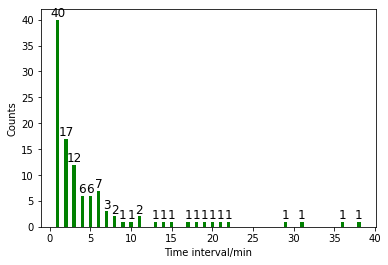

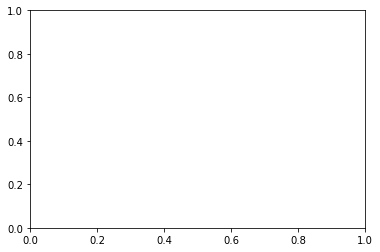

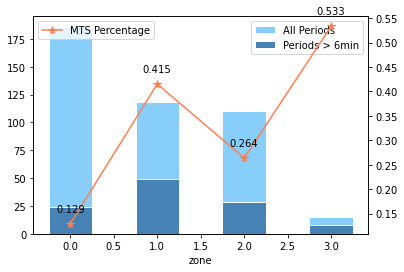

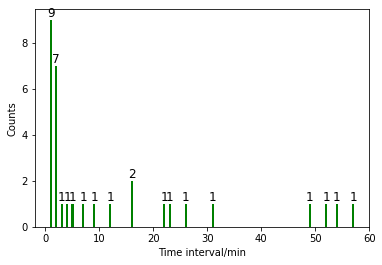

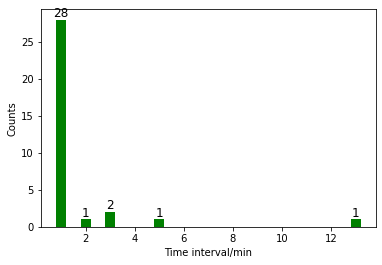

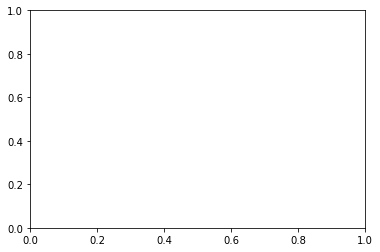

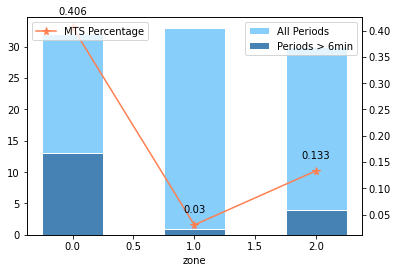

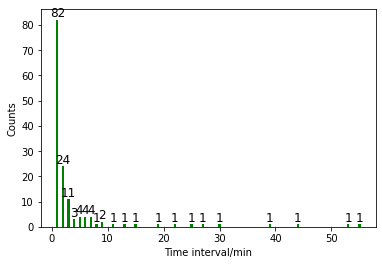

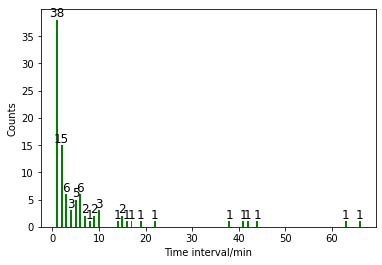

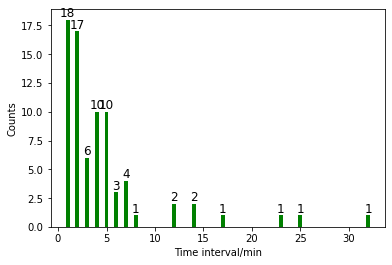

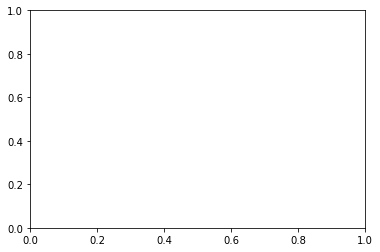

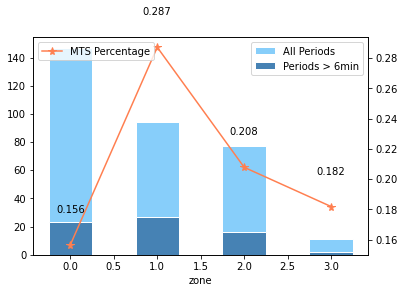

In [15]:
'''
data:df_long  data_allInOne  [Dataframe]
zone_info: zones_info_long   zones_info_forall  [Dataframe]
[zone分区编号  labels(list)所含网格编号  Area]
'''
def stay_time(data,zone_info,key):
    # key:分区名称-value:对应的分区字典[key:时间段-value:出现的次数]
    dict_periods={}
    # 高于6分钟的时间段占总时间段的比例  All:所有时间段数量  MTS: 高于6分钟时间段的数量
    MTS_info=pd.DataFrame(columns=['zone','All','MTS','MTSPercentage'])
    for idx,row in zone_info.iterrows(): # 每个分区
        labels_now=row['labels'] # 分区所含的所有网格编号
        periods=[]  # 所有时间段 (这一块儿是统计时长的？@段梦凡)
        
        count=0 # 计数 时间段长度
        for id,ro in data.iterrows():
            if ro['label'] in labels_now:
                count=count+1
            else:
                if count!=0:
                    periods.append(count)
                count=0
        set_periods=set(periods)
        dict={}
        for item in set_periods:
            dict.update({item:periods.count(item)}) # 某长度时间段出现的次数
        dict_periods.update({row['zone']:dict})
        
        pd1 = pd.DataFrame.from_dict(dict, orient='index')
        #print(pd1)
        writer = pd.ExcelWriter(datadir+'tmp/'+key+'_'+str(idx)+'_periods.xlsx')
        # write dataframe to excel
        pd1.to_excel(writer)
        # save the excel
        writer.save()

        # 画柱状图
        plt.figure()
        p1=plt.bar(list(dict.keys()),list(dict.values()) ,0.4,color="green")
        plt.bar_label(p1, label_type='edge',fontsize=12)
        plt.xlabel('Time interval/min')
        plt.ylabel('Counts')
        plt.savefig(res_path+key+"_zone="+str(row['zone'])+"_TimeIntervalCounts"+".png",dpi=300)
        
        # 计算数字特征
        MoreThanSix=0
        MTSlength=0
        AllPeriods=0
        Alllength=0
        for i in dict.keys():
            if int(i)>=6:
                MoreThanSix=MoreThanSix+dict[i]
                MTSlength=MTSlength+int(i)*dict[i]
            AllPeriods=AllPeriods+dict[i]
            Alllength=Alllength+int(i)*dict[i]
        MTSPercentage=MoreThanSix/AllPeriods
        print("zone:"+str(row['zone'])+":MTS="+str(MTSPercentage))

        
        newdf = pd.DataFrame({'zone':[ row['zone']],
        'All':[AllPeriods],
        'MTS':[MoreThanSix],
        'MTSPercentage':[MTSPercentage]})
        MTS_info=MTS_info.append(newdf,ignore_index=True)

    # 画MTS信息图
    # 绘柱状图
    plt.cla() #清空之前画的
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx() 
    
    x=list(MTS_info['zone'])
    y1=list(MTS_info['All'])
    y2=list(MTS_info['MTS'])
    y3=list(MTS_info['MTSPercentage'])
    
    ax1.bar(x, height=y1, label='All Periods',width = 0.5, facecolor='lightskyblue',edgecolor='white')
    ax1.bar(x, height=y2, label='Periods > 6min',width = 0.5, facecolor='steelblue',edgecolor='white')

    ax1.set_xlabel("zone")
    ax1.legend()
    
    # 画折线图
    ax2.plot(x, y3, "coral", ms=8, marker='*',label="MTS Percentage")
    # 在折线图上显示具体数值, ha参数控制水平对齐方式, va控制垂直对齐方式
    for x1, yy in zip(x, y3):
        ax2.text(x1, yy+0.02, str(round(yy, 3)), ha='center', va='bottom', fontsize=10, rotation=0)
    ax2.legend(loc="upper left")
    plt.savefig(res_path+key+"_MTSinfo"+".png",dpi=300)

    return dict_periods,MTS_info


periods_info_all,MTS_info_all=stay_time(data_allInOne,zones_info_forall,"All")
periods_info_long,MTS_info_long=stay_time(df_long,zones_info_long,"long")
periods_info_short,MTS_info_short=stay_time(df_short,zones_info_short,"short")
periods_info_mid,MTS_info_mid=stay_time(df_mid,zones_info_mid,"mid")